In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-score-classification/train.csv
/kaggle/input/credit-score-classification/test.csv


In [15]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import re    #Regular Expressions ( re ) module in Python
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder , OneHotEncoder
from tensorflow.keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

In [16]:
# Load the uploaded data
test_path = '/kaggle/input/credit-score-classification/test.csv'
train_path = '/kaggle/input/credit-score-classification/train.csv'

# Read the datasets
test_record = pd.read_csv(test_path)
train_record = pd.read_csv(train_path, low_memory=False)

In [17]:
# Display the first few rows of train record dataset
train_record.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [7]:
# Display the information in the train record dataset
train_record.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [8]:
# Display the last few rows of train record dataset
train_record.tail()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
99995,0x25fe9,CUS_0x942c,April,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,_,502.38,34.663572,31 Years and 6 Months,No,35.104023,60.97133255718485,High_spent_Large_value_payments,479.86622816574095,Poor
99996,0x25fea,CUS_0x942c,May,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,_,502.38,40.565631,31 Years and 7 Months,No,35.104023,54.18595028760385,High_spent_Medium_value_payments,496.651610435322,Poor
99997,0x25feb,CUS_0x942c,June,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,41.255522,31 Years and 8 Months,No,35.104023,24.02847744864441,High_spent_Large_value_payments,516.8090832742814,Poor
99998,0x25fec,CUS_0x942c,July,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,33.638208,31 Years and 9 Months,No,35.104023,251.67258219721603,Low_spent_Large_value_payments,319.1649785257098,Standard
99999,0x25fed,CUS_0x942c,August,Nicks,25,078-73-5990,Mechanic,39628.99_,3359.415833,4,...,Good,502.38,34.192463,31 Years and 10 Months,No,35.104023,167.1638651610451,!@9#%8,393.6736955618808,Poor


In [9]:
# Clean and prepare numerical columns for plotting ---
# Convert columns to numeric, coercing errors to NaN. This is a more robust way
# to handle non-numeric values (like strings or infinite values) in a numerical column.
for col in ['Credit_Utilization_Ratio', 'Monthly_Balance', 'Monthly_Inhand_Salary']:
    train_record[col] = pd.to_numeric(train_record[col], errors='coerce')
print("\nKey numerical columns have been cleaned and converted to numeric type.")


Key numerical columns have been cleaned and converted to numeric type.


In [10]:
# Display Descriptive Statistics (mean, median, std) for numerical features only ---
print("\n--- Descriptive Statistics for Numerical Features ---")
# Identify numerical columns (excluding the target variable)
numerical_features = train_record.select_dtypes(include=['float64', 'int64']).columns.tolist()
# Check for common non-numerical columns that might be misclassified
non_numerical = ['ID', 'Customer_ID']
numerical_features = [col for col in numerical_features if col not in non_numerical]
print(train_record[numerical_features].describe())


--- Descriptive Statistics for Numerical Features ---
       Monthly_Inhand_Salary  Num_Bank_Accounts  Num_Credit_Card  \
count           84998.000000      100000.000000     100000.00000   
mean             4194.170850          17.091280         22.47443   
std              3183.686167         117.404834        129.05741   
min               303.645417          -1.000000          0.00000   
25%              1625.568229           3.000000          4.00000   
50%              3093.745000           6.000000          5.00000   
75%              5957.448333           7.000000          7.00000   
max             15204.633333        1798.000000       1499.00000   

       Interest_Rate  Delay_from_due_date  Num_Credit_Inquiries  \
count  100000.000000        100000.000000          98035.000000   
mean       72.466040            21.068780             27.754251   
std       466.422621            14.860104            193.177339   
min         1.000000            -5.000000              0.000000 


--- Distribution of Credit_Score ---


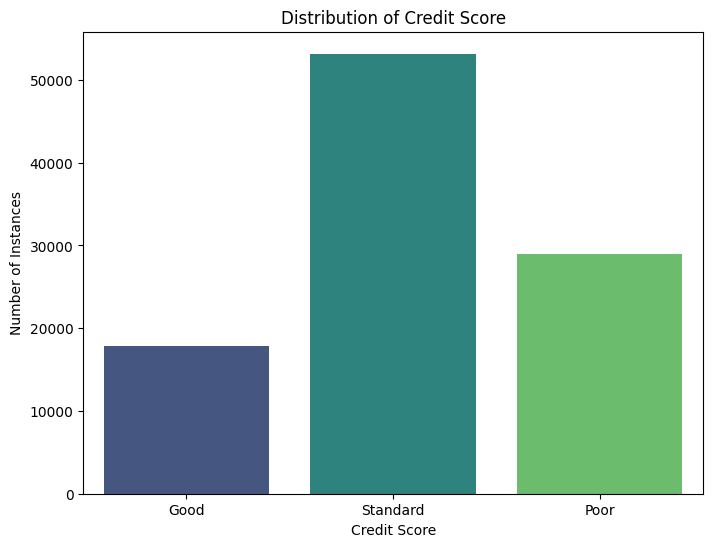

In [11]:
# Visualize the distribution of the target variable ---
print("\n--- Distribution of Credit_Score ---")
plt.figure(figsize=(8, 6))
sns.countplot(x='Credit_Score', data=train_record, palette='viridis')
plt.title('Distribution of Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Number of Instances')
plt.show()


--- Histograms for Key Numerical Features ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


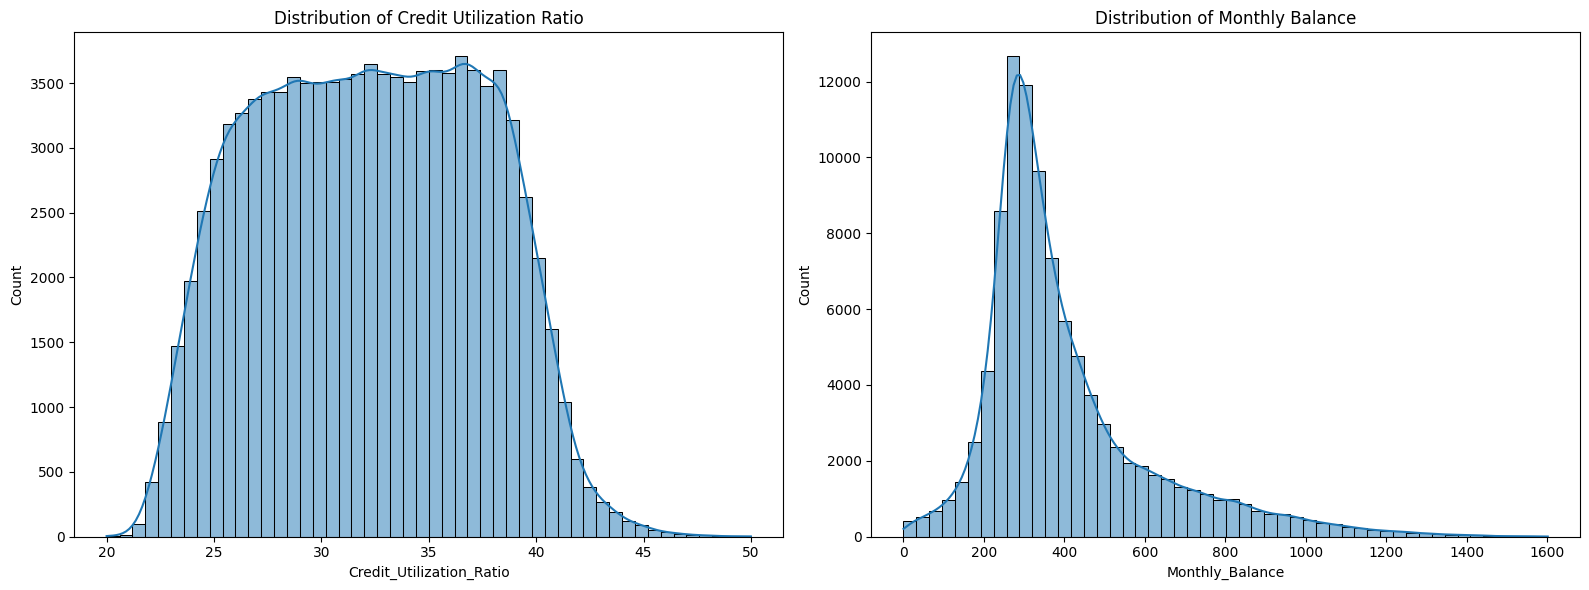

In [12]:
# Visualize the distribution of a numerical feature with a histogram ---
# This shows the frequency distribution of the data
print("\n--- Histograms for Key Numerical Features ---")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(train_record['Credit_Utilization_Ratio'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Credit Utilization Ratio')
sns.histplot(train_record['Monthly_Balance'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Monthly Balance')
plt.tight_layout()
plt.show()


--- Monthly_Inhand_Salary vs. Credit_Score ---


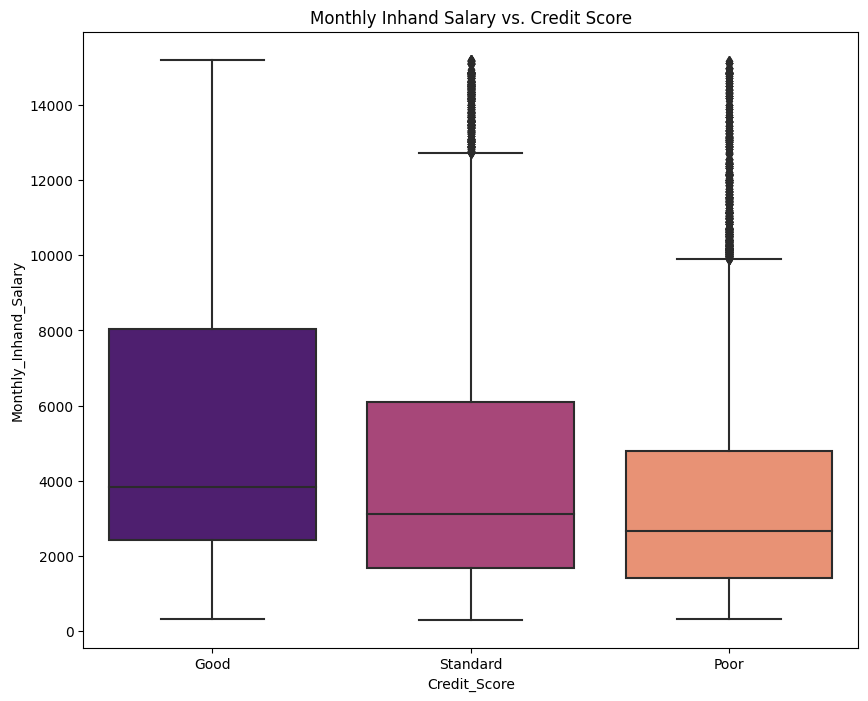

In [18]:
# Examine the relationship between two variables ---
# Box plot showing how Monthly_Inhand_Salary varies with Credit_Score
print("\n--- Monthly_Inhand_Salary vs. Credit_Score ---")
plt.figure(figsize=(10, 8))
sns.boxplot(x='Credit_Score', y='Monthly_Inhand_Salary', data=train_record, palette='magma')
plt.title('Monthly Inhand Salary vs. Credit Score')
plt.show()

In [ ]:
# Check a categorical feature with many unique values ---
print("\n--- Unique values in Type_of_Loan (first 10) ---")
print(train_record['Type_of_Loan'].value_counts().head(10))

In [ ]:
# Identify missing values
missing_summary = train_record.isnull().sum()
missing_summary

ID                              0
Customer_ID                     0
Month                           0
Name                         9985
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1209
Credit_Score                    0
dtype: int64

In [ ]:
# Identify missing values
missing_summary = test_record.isnull().sum()
missing_summary

ID                             0
Customer_ID                    0
Month                          0
Name                        5015
Age                            0
SSN                            0
Occupation                     0
Annual_Income                  0
Monthly_Inhand_Salary       7498
Num_Bank_Accounts              0
Num_Credit_Card                0
Interest_Rate                  0
Num_of_Loan                    0
Type_of_Loan                5704
Delay_from_due_date            0
Num_of_Delayed_Payment      3498
Changed_Credit_Limit           0
Num_Credit_Inquiries        1035
Credit_Mix                     0
Outstanding_Debt               0
Credit_Utilization_Ratio       0
Credit_History_Age          4470
Payment_of_Min_Amount          0
Total_EMI_per_month            0
Amount_invested_monthly     2271
Payment_Behaviour              0
Monthly_Balance              562
dtype: int64

In [ ]:
# Drop columns with more than 50% missing values (adjust threshold as needed)
threshold = len(train_record) * 0.5
train_record = train_record.dropna(axis=1, thresh=threshold)

In [ ]:
# Drop columns with more than 50% missing values (adjust threshold as needed)
threshold = len(test_record) * 0.5
test_record = test_record.dropna(axis=1, thresh=threshold)

In [ ]:
# Fill missing numeric values with the median
numeric_cols = train_record.select_dtypes(include=['float64', 'int64']).columns
train_record[numeric_cols] = train_record[numeric_cols].fillna(train_record[numeric_cols].median())

# Fill missing categorical values with the mode
categorical_cols = train_record.select_dtypes(include=['object']).columns
for col in categorical_cols:
    train_record[col] = train_record[col].fillna(train_record[col].mode()[0])

In [20]:
# Fill missing numeric values with the median
numeric_cols = test_record.select_dtypes(include=['float64', 'int64']).columns
test_record[numeric_cols] = test_record[numeric_cols].fillna(test_record[numeric_cols].median())

# Fill missing categorical values with the mode
categorical_cols = test_record.select_dtypes(include=['object']).columns
for col in categorical_cols:
    test_record[col] = test_record[col].fillna(test_record[col].mode()[0])

In [21]:
# Verify there are no remaining missing values
print("Remaining missing values:\n", train_record.isnull().sum())

Remaining missing values:
 ID                          0
Customer_ID                 0
Month                       0
Name                        0
Age                         0
SSN                         0
Occupation                  0
Annual_Income               0
Monthly_Inhand_Salary       0
Num_Bank_Accounts           0
Num_Credit_Card             0
Interest_Rate               0
Num_of_Loan                 0
Type_of_Loan                0
Delay_from_due_date         0
Num_of_Delayed_Payment      0
Changed_Credit_Limit        0
Num_Credit_Inquiries        0
Credit_Mix                  0
Outstanding_Debt            0
Credit_Utilization_Ratio    0
Credit_History_Age          0
Payment_of_Min_Amount       0
Total_EMI_per_month         0
Amount_invested_monthly     0
Payment_Behaviour           0
Monthly_Balance             0
Credit_Score                0
dtype: int64


In [22]:
# Verify there are no remaining missing values
print("Remaining missing values:\n", test_record.isnull().sum())

Remaining missing values:
 ID                          0
Customer_ID                 0
Month                       0
Name                        0
Age                         0
SSN                         0
Occupation                  0
Annual_Income               0
Monthly_Inhand_Salary       0
Num_Bank_Accounts           0
Num_Credit_Card             0
Interest_Rate               0
Num_of_Loan                 0
Type_of_Loan                0
Delay_from_due_date         0
Num_of_Delayed_Payment      0
Changed_Credit_Limit        0
Num_Credit_Inquiries        0
Credit_Mix                  0
Outstanding_Debt            0
Credit_Utilization_Ratio    0
Credit_History_Age          0
Payment_of_Min_Amount       0
Total_EMI_per_month         0
Amount_invested_monthly     0
Payment_Behaviour           0
Monthly_Balance             0
dtype: int64


In [23]:
# Identify the target variable ---
# Based on the problem description, the target variable (or 'label') is 'Credit_Score'.
# Let's check the unique values and their counts in this column.
print("\nUnique values in the 'Credit_Score' column:")
print(train_record['Credit_Score'].value_counts())


Unique values in the 'Credit_Score' column:
Credit_Score
Standard    53174
Poor        28998
Good        17828
Name: count, dtype: int64


In [24]:
# Encode the categorical labels ---
# Machine learning models require numerical input. The 'Credit_Score' labels
# ('Good', 'Standard', 'Poor') are categorical strings. We need to convert them
# into numerical representations. Label Encoding is a suitable method here.
# 'LabelEncoder' assigns a unique integer to each unique category.

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

In [25]:
# Fit the encoder to the 'Credit_Score' column and transform the labels
train_record['Credit_Score_Encoded'] = label_encoder.fit_transform(train_record['Credit_Score'])

In [26]:
# Show the mapping from original labels to encoded integers
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nLabel Encoding Mapping:")
print(label_mapping)


Label Encoding Mapping:
{'Good': 0, 'Poor': 1, 'Standard': 2}


In [27]:
# Display the first few rows with the new encoded column to verify the transformation
print("\nFirst 5 rows of the DataFrame with the new encoded label:")
print(train_record[['Credit_Score', 'Credit_Score_Encoded']].head())


First 5 rows of the DataFrame with the new encoded label:
  Credit_Score  Credit_Score_Encoded
0         Good                     0
1         Good                     0
2         Good                     0
3         Good                     0
4         Good                     0


In [28]:
# Display the last few rows with the new encoded column to verify the transformation
print("\nLast 5 rows of the DataFrame with the new encoded label:")
print(train_record[['Credit_Score', 'Credit_Score_Encoded']].tail())


Last 5 rows of the DataFrame with the new encoded label:
      Credit_Score  Credit_Score_Encoded
99995         Poor                     1
99996         Poor                     1
99997         Poor                     1
99998     Standard                     2
99999         Poor                     1


In [29]:
# Prepare data for model training ---
# Separate the features (X) from the labels (y)
# 'Credit_Score' is the original string label, and 'Credit_Score_Encoded' is the numerical one.
# 'ID' and 'Customer_ID' are identifiers and should be dropped. 'Credit_Score' is the original label and should be dropped from features.
x = train_record.drop(columns=['ID', 'Customer_ID', 'Credit_Score', 'Credit_Score_Encoded']) # features
y = train_record['Credit_Score_Encoded'] # labels


In [30]:
print("\nShape of the features matrix (X):", x.shape)
print("Shape of the labels vector (y):", y.shape)
print("\nLabels are now ready for model training!")


Shape of the features matrix (X): (100000, 25)
Shape of the labels vector (y): (100000,)

Labels are now ready for model training!


In [31]:
# --- 3. Split the data *before* preprocessing ---
# We split the original, unprocessed data to save memory.
X_train, X_val, y_train, y_val = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [32]:
print("\nData has been successfully split into training and validation sets.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape:   {X_val.shape}")
print(f"y_val shape:   {y_val.shape}")


Data has been successfully split into training and validation sets.
X_train shape: (80000, 25)
y_train shape: (80000,)
X_val shape:   (20000, 25)
y_val shape:   (20000,)


In [33]:
# Identify categorical and numerical features ---
# We need to distinguish between columns we'll one-hot encode and columns we'll pass through.
categorical_features = x.select_dtypes(include=['object']).columns
numerical_features = x.select_dtypes(include=['int64', 'float64']).columns

print(f"\nCategorical features identified: {list(categorical_features)}")
print(f"Numerical features identified: {list(numerical_features)}")


Categorical features identified: ['Month', 'Name', 'Age', 'SSN', 'Occupation', 'Annual_Income', 'Num_of_Loan', 'Type_of_Loan', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Credit_Mix', 'Outstanding_Debt', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Amount_invested_monthly', 'Payment_Behaviour']
Numerical features identified: ['Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Delay_from_due_date', 'Num_Credit_Inquiries', 'Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Monthly_Balance']


In [34]:
# Create a memory-efficient preprocessing pipeline ---
# Use sparse_output=True in OneHotEncoder to save memory.
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        # Apply OneHotEncoder to the categorical features
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_features),
        # Apply MinMaxScaler to the numerical features
        ('scaler', MinMaxScaler(), numerical_features)
    ],
    remainder='drop' # Drop any other columns not specified
)


In [35]:
# Apply preprocessing to the split data ---
# We fit the preprocessor on the training data. This learns the min/max values and
# the categories from the training set only.
X_train_processed = preprocessor.fit_transform(X_train)

# We then transform the validation set using the parameters learned from the training set.
# This prevents data leakage and ensures the validation data is processed correctly.
X_val_processed = preprocessor.transform(X_val)



In [36]:
# Build the sequential model

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_processed.shape[1],)),
    Dropout(0.3),  # Added dropout for regularization
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'), # A new dense layer
    Dense(8, activation='relu'),  # Another new dense layer
    Dense(3, activation='softmax') # Output layer for 3 classes
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1757251891.787624      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757251891.788271      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [37]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │    17,871,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,882,899 (68.22 MB)

 Trainable params: 17,882,899 (68.22 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Train the model
history = model.fit(X_train_processed, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20


I0000 00:00:1757251895.837753     114 service.cc:148] XLA service 0x47e04df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757251895.838262     114 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757251895.838279     114 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757251896.130307     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2000 ━━━━━━━━━━━━━━━━━━━━ 2:37:05 5s/step - accuracy: 0.2188 - loss: 1.0986

I0000 00:00:1757251898.053814     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 0.6334 - loss: 0.7673 - val_accuracy: 0.7979 - val_loss: 0.4874
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8574 - loss: 0.3348 - val_accuracy: 0.8111 - val_loss: 0.4612
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9113 - loss: 0.2095 - val_accuracy: 0.8173 - val_loss: 0.5165
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9498 - loss: 0.1229 - val_accuracy: 0.8086 - val_loss: 0.6464
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9727 - loss: 0.0717 - val_accuracy: 0.8092 - val_loss: 0.7637
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9856 - loss: 0.0393 - val_accuracy: 0.8093 - val_loss: 0.9373
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9914 - loss: 0.0240 - val_accuracy: 0.8120 - val_loss: 1.0807
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9939 - loss: 0.0165 - va

In [47]:
# Save the trained model 
import joblib
joblib.dump(model, 'credit_score_nn_model.joblib')

['credit_score_nn_model.joblib']

In [40]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val_processed, y_val, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7973 - loss: 1.6531
Test Accuracy: 79.48%


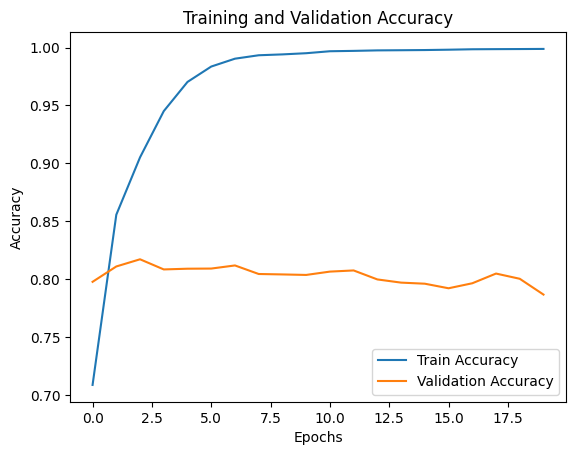

In [41]:
# Plot training history 
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [44]:
# y_pred = (model.predict(X_val_processed) > 0.5).astype(int)

y_pred_probs = model.predict(X_val_processed)
y_pred = np.argmax(y_pred_probs, axis=1)
y_pred

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step


array([1, 1, 1, ..., 2, 0, 1])

In [45]:
from sklearn.metrics import classification_report
print("\nClassification Report ")
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))


Classification Report 
              precision    recall  f1-score   support

        Good       0.82      0.67      0.74      3566
        Poor       0.82      0.76      0.79      5799
    Standard       0.78      0.86      0.82     10635

    accuracy                           0.79     20000
   macro avg       0.80      0.76      0.78     20000
weighted avg       0.80      0.79      0.79     20000



In [46]:

# Transform the numerical predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred)

print(y_pred_labels)


['Poor' 'Poor' 'Poor' ... 'Standard' 'Good' 'Poor']


In [48]:
joblib.dump(preprocessor, 'preprocessor.joblib')
joblib.dump(label_encoder, 'label_encoder.joblib')
print("Preprocessor and LabelEncoder saved as '.joblib' files.")

Preprocessor and LabelEncoder saved as '.joblib' files.


In [51]:
app_code = """import streamlit as st
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
import os

# Set the path to the working directory in Kaggle
working_dir = '/kaggle/working/'

# --- 1. Load the trained model and preprocessor components ---
try:
    # Load the trained Keras model as a joblib file
    model_path = os.path.join(working_dir, 'credit_score_nn_model.joblib')
    model = joblib.load(model_path)
    # Load the preprocessor and label encoder
    preprocessor_path = os.path.join(working_dir, 'preprocessor.joblib')
    preprocessor = joblib.load(preprocessor_path)
    label_encoder_path = os.path.join(working_dir, 'label_encoder.joblib')
    label_encoder = joblib.load(label_encoder_path)
except FileNotFoundError:
    st.error("Error: Model or preprocessing files not found. Please run the training script first to create them.")
    st.stop()

# --- 2. Define the app title and form ---
st.title("Credit Score Prediction App")
st.write("Enter the customer's information below to predict the credit score (Poor, Standard, or Good).")

with st.form("prediction_form"):
    st.header("Customer Data")
    
    # Input fields
    annual_income = st.number_input("Annual Income", min_value=0.0, format="%.2f")
    monthly_inhand_salary = st.number_input("Monthly Inhand Salary", min_value=0.0, format="%.2f")
    num_bank_accounts = st.number_input("Number of Bank Accounts", min_value=0, step=1)
    num_credit_card = st.number_input("Number of Credit Cards", min_value=0, step=1)
    interest_rate = st.number_input("Interest Rate", min_value=0.0, format="%.2f")
    num_of_loan = st.number_input("Number of Loans", min_value=0, step=1)
    delay_from_due_date = st.number_input("Delay from Due Date (in days)", min_value=0, step=1)
    num_of_delayed_payment = st.number_input("Number of Delayed Payments", min_value=0, step=1)
    changed_credit_limit = st.number_input("Changed Credit Limit", min_value=0.0, format="%.2f")
    num_credit_inquiries = st.number_input("Number of Credit Inquiries", min_value=0, step=1)
    outstanding_debt = st.number_input("Outstanding Debt", min_value=0.0, format="%.2f")
    credit_utilization_ratio = st.number_input("Credit Utilization Ratio", min_value=0.0, format="%.2f")
    total_emi_per_month = st.number_input("Total EMI per Month", min_value=0.0, format="%.2f")
    amount_invested_monthly = st.number_input("Amount Invested Monthly", min_value=0.0, format="%.2f")
    monthly_balance = st.number_input("Monthly Balance", min_value=0.0, format="%.2f")
    credit_history_age_str = st.text_input("Credit History Age (e.g., 15 Years and 3 Months)")
    
    # Categorical features
    occupation = st.selectbox("Occupation", ["Scientist", "Mechanic", "Architect", "Engineer"])
    credit_mix = st.selectbox("Credit Mix", ["Good", "Standard", "Bad"])
    payment_of_min_amount = st.selectbox("Payment of Min Amount", ["No", "Yes"])
    payment_behaviour = st.selectbox("Payment Behaviour", ["High_spent_Small_value_payments", "Low_spent_Small_value_payments", "High_spent_Medium_value_payments"])
    
    # Submit button
    submitted = st.form_submit_button("Predict Credit Score")

    if submitted:
        # --- 3. Process the input and make a prediction ---
        # Convert credit history age to months
        try:
            parts = credit_history_age_str.replace('and', '').replace('Months', '').replace('Years', '').split()
            years = int(parts[0])
            months = int(parts[1])
            credit_history_age_months = years * 12 + months
        except (ValueError, IndexError):
            st.warning("Please enter the credit history age in the correct format.")
            st.stop()
            
        # Create a DataFrame from the user's input
        input_data = pd.DataFrame([{
            'Annual_Income': annual_income,
            'Monthly_Inhand_Salary': monthly_inhand_salary,
            'Num_Bank_Accounts': num_bank_accounts,
            'Num_Credit_Card': num_credit_card,
            'Interest_Rate': interest_rate,
            'Num_of_Loan': num_of_loan,
            'Delay_from_due_date': delay_from_due_date,
            'Num_of_Delayed_Payment': num_of_delayed_payment,
            'Changed_Credit_Limit': changed_credit_limit,
            'Num_Credit_Inquiries': num_credit_inquiries,
            'Outstanding_Debt': outstanding_debt,
            'Credit_Utilization_Ratio': credit_utilization_ratio,
            'Total_EMI_per_month': total_emi_per_month,
            'Amount_invested_monthly': amount_invested_monthly,
            'Monthly_Balance': monthly_balance,
            'Occupation': occupation,
            'Credit_Mix': credit_mix,
            'Payment_of_Min_Amount': payment_of_min_amount,
            'Payment_Behaviour': payment_behaviour,
            'Credit_History_Age_Months': credit_history_age_months
        }])
        
        # Preprocess the input data using the saved preprocessor
        processed_input = preprocessor.transform(input_data)
        
        # Make a prediction
        prediction_prob = model.predict(processed_input)
        prediction = np.argmax(prediction_prob, axis=1)
        
        # Convert the numerical prediction back to a label
        predicted_label = label_encoder.inverse_transform(prediction)[0]
        
        # --- 4. Display the result ---
        if predicted_label == 'Good':
            st.success(f"Prediction Result: {predicted_label}")
        elif predicted_label == 'Standard':
            st.info(f"Prediction Result: {predicted_label}")
        else:
            st.warning(f"Prediction Result: {predicted_label}")
"""



In [52]:
with open('/kaggle/working/app.py', 'w') as f:
    f.write(app_code)
print("app.py saved successfully to /kaggle/working/")

app.py saved successfully to /kaggle/working/


In [54]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 46.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 88.4 MB/s eta 0:00:00:00:0100:01


In [57]:
!streamlit run /kaggle/working/app.py --server.address=0.0.0.0




  You can now view your Streamlit app in your browser.

  URL: http://0.0.0.0:8501

^C
  Stopping...


In [60]:
# Define the content for requirements.txt
Project_Requirements = """ streamlit
pandas
Numpy
scikit-learn
joblib
tensorflow
Keras
matplotlib
seaborn 
"""

In [61]:
with open('/kaggle/working/requirements.txt', 'w') as f:
    f.write(Project_Requirements)
print("requirements.txt saved successfully to /kaggle/working/")

requirements.txt saved successfully to /kaggle/working/


In [62]:
# Define the content for the Dockerfile
dockerfile_content = """
# Use a Python base image
FROM python:3.11-slim

# Set the working directory in the container
WORKDIR /app

# Copy the requirements file and install the dependencies
COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

# Copy all the necessary files into the container
COPY . .

# Expose the port that Streamlit runs on
EXPOSE 8501

# Command to run the Streamlit application
CMD ["streamlit", "run", "app.py", "--server.address=0.0.0.0"]
"""

In [63]:
with open('/kaggle/working/DockerFile', 'w') as f:
    f.write(dockerfile_content)
print("DockerFile saved successfully to /kaggle/working/")

DockerFile saved successfully to /kaggle/working/
